In [53]:
library(regioneR)
library(rtracklayer)
library(ggplot2)
library(tidyr)
library(dplyr)
library(plotly)
library(BSgenome.Hsapiens.UCSC.hg19)

library("multcomp")

ERROR: Error in library("multcomp"): there is no package called ‘multcomp’


# Import Data

## Mappability bed file

The mappability bed file specifies the regions where the sequencing strategy can detect cleavage events.

In [3]:
map_bed <- toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/mappability.stranded.hg38.bed',
                                sep='\t'))

In [4]:
map_bed_chr19 <- map_bed[map_bed@seqnames == 'chr19']

## Consensus

In [5]:
consensus_bed <- toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/consensus_footprints_and_collapsed_motifs_hg38.bed',
                                sep='\t'))

In [6]:
consensus_bed_chr19 <- consensus_bed[consensus_bed@seqnames == 'chr19']

## CD20 Footprints 

In [32]:
cd20_beds <- list(cd20_0.0001 = toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/interval.all.fps.0.0001.bed', sep='\t')),
                  cd20_0.001 = toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/interval.all.fps.0.001.bed',sep='\t')),
                  cd20_0.01 = toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/interval.all.fps.0.01.bed',sep='\t')),
                  cd20_0.05 = toGRanges(read.table('/home/jupyter/human-TF-footprinting/Data/interval.all.fps.0.05.bed',sep='\t')))

## Interval.all.bedgraph

Per-nucleotide footprint statistics

In [7]:
cd20_all <- toGRanges('/home/jupyter/human-TF-footprinting/Data/interval.all.bedgraph')

In [8]:
cd20_all_chr19 <- cd20_all[cd20_all@seqnames == 'chr19']

# Consensus Analysis

In [8]:
consensus.analysis <- function(bed_list,
                               map_bed,
                               consensus_bed){
    
    print(paste('Number of regions in mappable regions: ', nrow(toDataframe(map_bed)), 
                sep=' '))
    
    cat('\n')

    print(paste('Number of regions in the consensus: ', nrow(toDataframe(consensus_bed)), 
                sep=' '))
    
    cat('\n')

    
    # number of regions in dataset of interest
    for (bed_df in names(bed_list)) {
        print(paste(bed_df, 'number of regions:', nrow(toDataframe(bed_list[[bed_df]])), sep=' '))
    }
    
    cat('\n')
    
    # check if the dataset of interest is a proper subset of mappable regions
        for (bed_df in names(bed_list)) {
            print(bed_df)
            print(paste('Number of overlaps in mappable regions:',
                        numOverlaps(bed_list[[bed_df]], 
                                    map_bed, 
                                    count.once=TRUE), sep=' '))
            print(paste('Number of overlaps in consensus:', 
                        numOverlaps(bed_list[[bed_df]], 
                                    consensus_bed, 
                                    count.once=TRUE), sep=' '))
            cat('\n')

        }
    
}

# consensus.analysis(cd20_beds, map_bed, consensus_bed)
# Subset cd20+ bcells to Chr19
for (bed_df in names(cd20_beds)) {
    cd20_beds[[bed_df]] <- cd20_beds[[bed_df]][cd20_beds[[bed_df]]@seqnames == "chr19"]
}
consensus.analysis(cd20_beds, map_bed_chr19, consensus_bed_chr19) # cd20_beds filtered to chr19

# Export chr19 subset data
# write.table(map_bed_chr19, "/home/jupyter/human-TF-footprinting/Data/mappability.stranded.hg38.chr19.bed", append = TRUE, sep = "")
# write.table(consensus_bed_chr19, "/home/jupyter/human-TF-footprinting/Data/consensus_footprints_and_collapsed_motifs_hg38_chr19.bed", append = TRUE, sep = "")
# write.table(cd20_all_chr19, "/home/jupyter/human-TF-footprinting/Data/interval.all.chr19.bed", append = TRUE, sep = "")

[1] "Number of regions in mappable regions:  1833378"

[1] "Number of regions in the consensus:  126666"

[1] "cd20_0.0001 number of regions: 9661"
[1] "cd20_0.001 number of regions: 14646"
[1] "cd20_0.01 number of regions: 28221"
[1] "cd20_0.05 number of regions: 50162"

[1] "cd20_0.0001"
[1] "Number of overlaps in mappable regions: 9554"
[1] "Number of overlaps in consensus: 9146"

[1] "cd20_0.001"
[1] "Number of overlaps in mappable regions: 14479"
[1] "Number of overlaps in consensus: 13126"

[1] "cd20_0.01"
[1] "Number of overlaps in mappable regions: 27879"
[1] "Number of overlaps in consensus: 21812"

[1] "cd20_0.05"
[1] "Number of overlaps in mappable regions: 49551"
[1] "Number of overlaps in consensus: 32613"



In [9]:
avg_numsamples_per_chr.names <- unlist(unique(consensus_bed@seqnames))
avg_numsamples_per_chr <- rep(NA, length(avg_numsamples_per_chr.names))
names(avg_numsamples_per_chr) <- avg_numsamples_per_chr.names
for (chr in unique(consensus_bed@seqnames)){
    avg_numsamples_per_chr[[chr]] <- mean(consensus_bed[consensus_bed@seqnames == chr]$V6)
}
avg_numsamples_per_chr_df <- data.frame(avg_numsamples_per_chr)

In [10]:
head(consensus_bed)

GRanges object with 6 ranges and 9 metadata columns:
    seqnames        ranges strand |          V4        V5        V6        V7
       <Rle>     <IRanges>  <Rle> | <character> <numeric> <integer> <integer>
  1     chr1 180787-180831      * |  1.100643.4  92.52789         6         6
  2     chr1 180848-180867      * |  1.100643.7  44.63207         7         8
  3     chr1 181109-181118      * |  1.100647.1   4.99347         1         1
  4     chr1 181134-181154      * |  1.100647.4  70.43005         7         7
  5     chr1 181172-181215      * |  1.100647.7  17.03391         2         2
  6     chr1 181306-181336      * |  1.100651.1 188.82697        18        31
           V8        V9       V10       V11                    V12
    <integer> <integer> <integer> <integer>            <character>
  1        44    180802    180784    180808 KLF/SP/2;NR/11;NR/12..
  2        19    180856    180853    180862               KLF/SP/2
  3         9    181113    181113    181113            

In [11]:
avg_numsamples_per_chr_df

,avg_numsamples_per_chr
,<dbl>
chr1,11.598195
chr10,9.776064
chr11,11.466149
chr12,11.159547
chr13,8.410232
chr14,10.931864
chr15,10.934215
chr16,12.371862
chr17,13.943751


# Boxplot Analysis

In [12]:
dhs.boxplot <- function(boxplot_df,
                       title,
                       x_label,
                       y_label){
    ggplot(boxplot_df, aes(x=X, y=Y)) +
    geom_boxplot(outlier.shape = NA) + coord_cartesian(ylim = quantile(boxplot_df$Y, c(0.01, .94))) +
    theme(axis.text.x=element_text(angle=45,margin = margin(1, unit = "cm"),vjust =1)) + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.line = element_line(colour = "black")) + 
    labs(title=title,
         x=x_label,
         y=y_label)
}

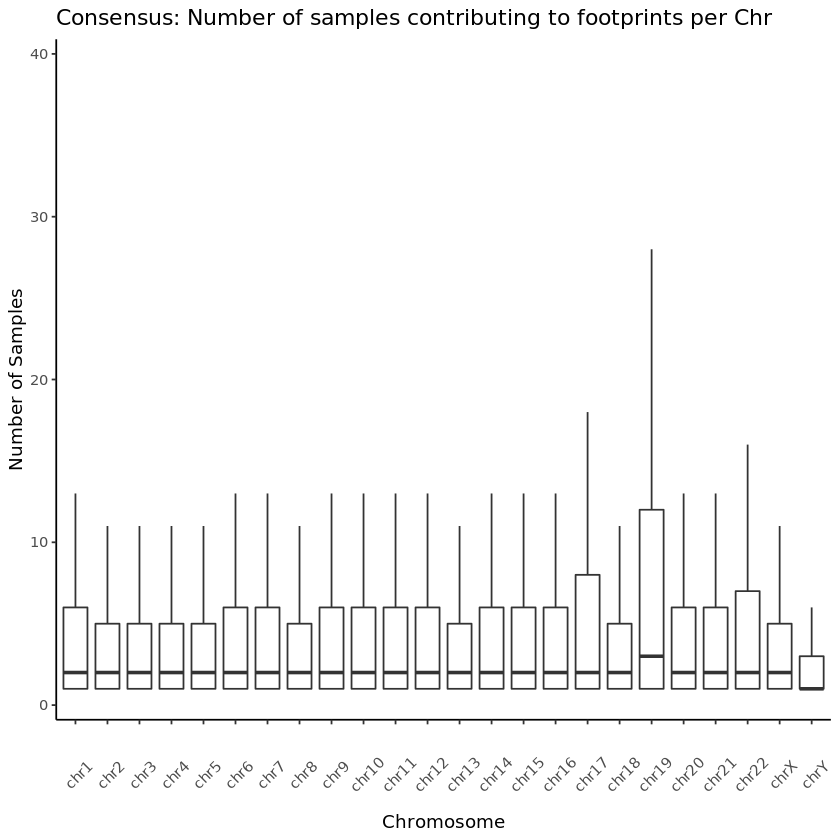

In [19]:
consensus_boxplot_df <- data.frame(X=consensus_bed@seqnames,Y=consensus_bed$V6)
rename.chr <- paste(rep('chr',24),seq(1, 24, by=1),sep='')
rename.chr[[24]] <- 'chrY'
rename.chr[[23]] <- 'chrX'
consensus_boxplot_df$X <- factor(consensus_boxplot_df$X, levels=rename.chr)

dhs.boxplot(consensus_boxplot_df,
           "Consensus: Number of samples contributing to footprints per Chr",
           "Chromosome",
           "Number of Samples")

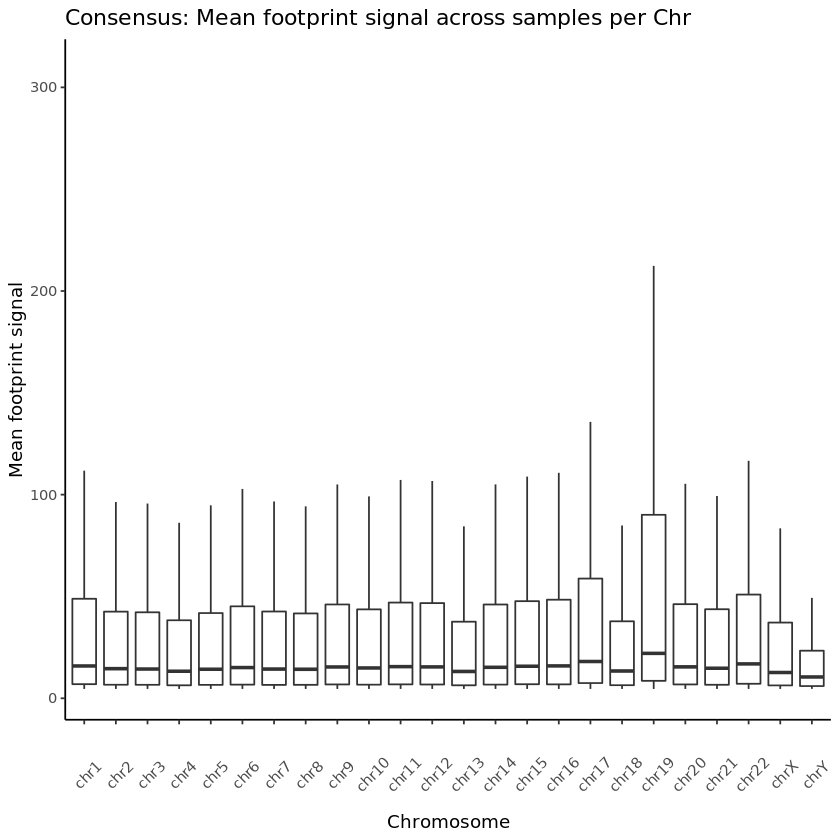

In [20]:
consensus_boxplot_df <- data.frame(X=consensus_bed@seqnames,Y=consensus_bed$V5)
rename.chr <- paste(rep('chr',24),seq(1, 24, by=1),sep='')
rename.chr[[24]] <- 'chrY'
rename.chr[[23]] <- 'chrX'
consensus_boxplot_df$X <- factor(consensus_boxplot_df$X, levels=rename.chr)

dhs.boxplot(consensus_boxplot_df,
           "Consensus: Mean footprint signal across samples per Chr",
           "Chromosome",
           "Mean footprint signal")

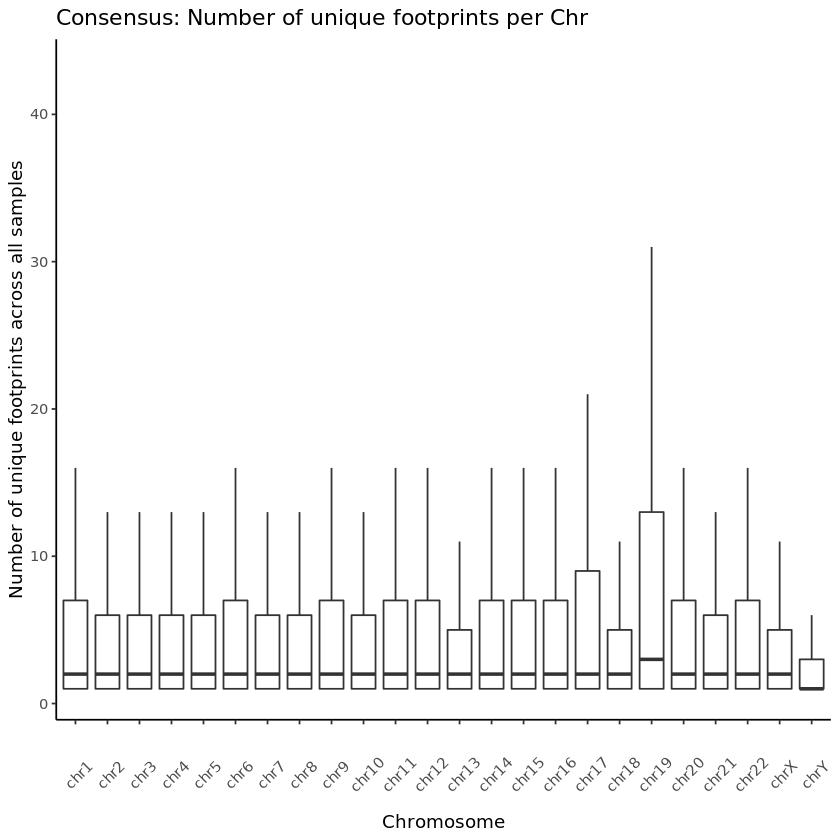

In [22]:
consensus_boxplot_df <- data.frame(X=consensus_bed@seqnames,Y=consensus_bed$V7)
rename.chr <- paste(rep('chr',24),seq(1, 24, by=1),sep='')
rename.chr[[24]] <- 'chrY'
rename.chr[[23]] <- 'chrX'
consensus_boxplot_df$X <- factor(consensus_boxplot_df$X, levels=rename.chr)


dhs.boxplot(consensus_boxplot_df,
           "Consensus: Number of unique footprints per Chr",
           "Chromosome",
           "Number of unique footprints across all samples")


In [48]:
count_footprint_per_chr.names <- unlist(unique(cd20_beds[['cd20_0.0001']]@seqnames))
count_footprint_per_chr <- rep(NA, length(count_footprint_per_chr.names))
names(count_footprint_per_chr) <- count_footprint_per_chr.names

for (chr in unique(cd20_beds[['cd20_0.0001']]@seqnames)){
    count_footprint_per_chr[chr] <- nrow(toDataframe(cd20_beds[['cd20_0.0001']][cd20_beds[['cd20_0.0001']]@seqnames == chr]))
}
count_footprint_per_chr_df <- data.frame(count_footprint_per_chr)

rename.chr <- paste(rep('chr',24),seq(1, 24, by=1),sep='')
rename.chr[[24]] <- 'chrY'
rename.chr[[23]] <- 'chrX'
count_footprint_per_chr_df$chr <- row.names(count_footprint_per_chr_df)
count_footprint_per_chr_df$chr <- factor(count_footprint_per_chr_df$chr, levels=rename.chr)

In [49]:
count_footprint_per_chr_df

,count_footprint_per_chr,chr
,<int>,<fct>
chr1,11657,chr1
chr10,4807,chr10
chr11,6104,chr11
chr12,5932,chr12
chr13,2017,chr13
chr14,3984,chr14
chr15,3559,chr15
chr16,5126,chr16
chr17,7228,chr17


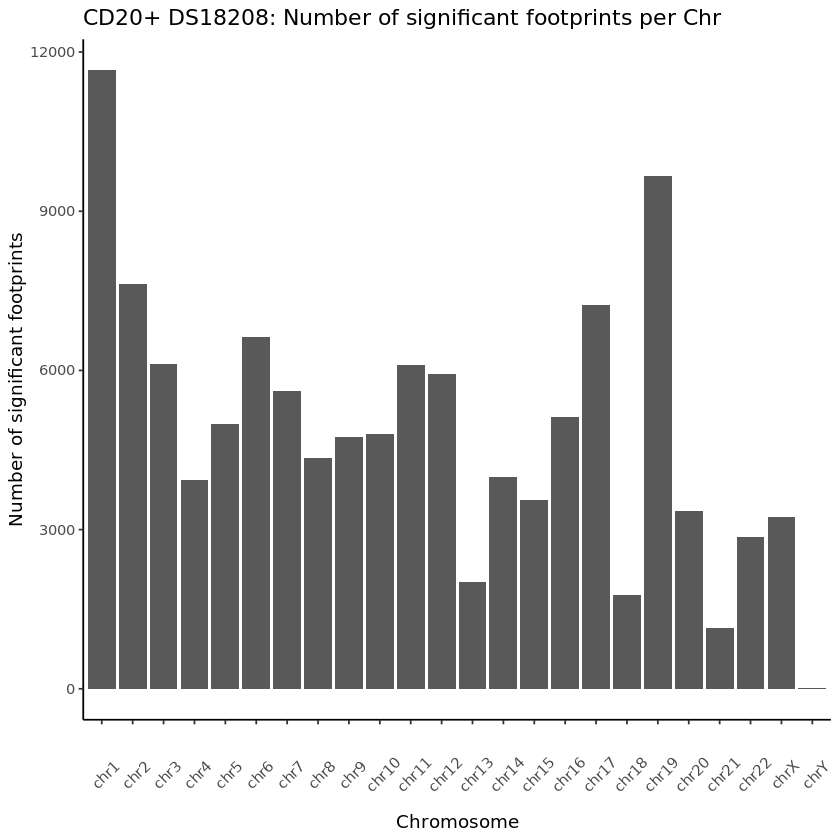

In [52]:
ggplot(data=count_footprint_per_chr_df, aes(x=chr, y=count_footprint_per_chr)) +
  geom_bar(stat="identity") +
theme(axis.text.x=element_text(angle=45,margin = margin(1, unit = "cm"),vjust =1)) + 
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      panel.background = element_blank(), axis.line = element_line(colour = "black"))+ 
    labs(title='CD20+ DS18208: Number of significant footprints per Chr',
         x='Chromosome',
         y='Number of significant footprints')

In [40]:
g <- glht(m, linfct = mcp(Species = "Tukey"))
summary(g, test = adjusted("holm"))

In [181]:
cd20_beds[['cd20_0.05']]$V6 <- as.integer(1)
cd20_boxplot_df <- data.frame(X=cd20_beds[['cd20_0.05']]@seqnames,Y=cd20_beds[['cd20_0.05']]$V6)

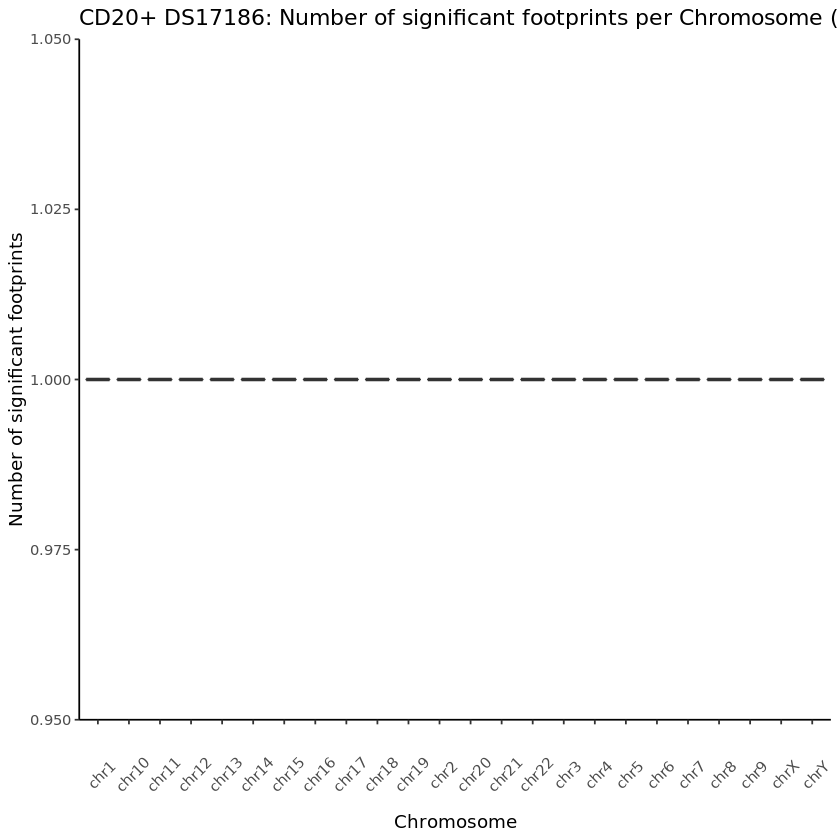

In [182]:
dhs.boxplot(cd20_boxplot_df, 
            "CD20+ DS17186: Number of significant footprints per Chromosome (FDR <= 0.05)",
            "Chromosome",
            "Number of significant footprints")

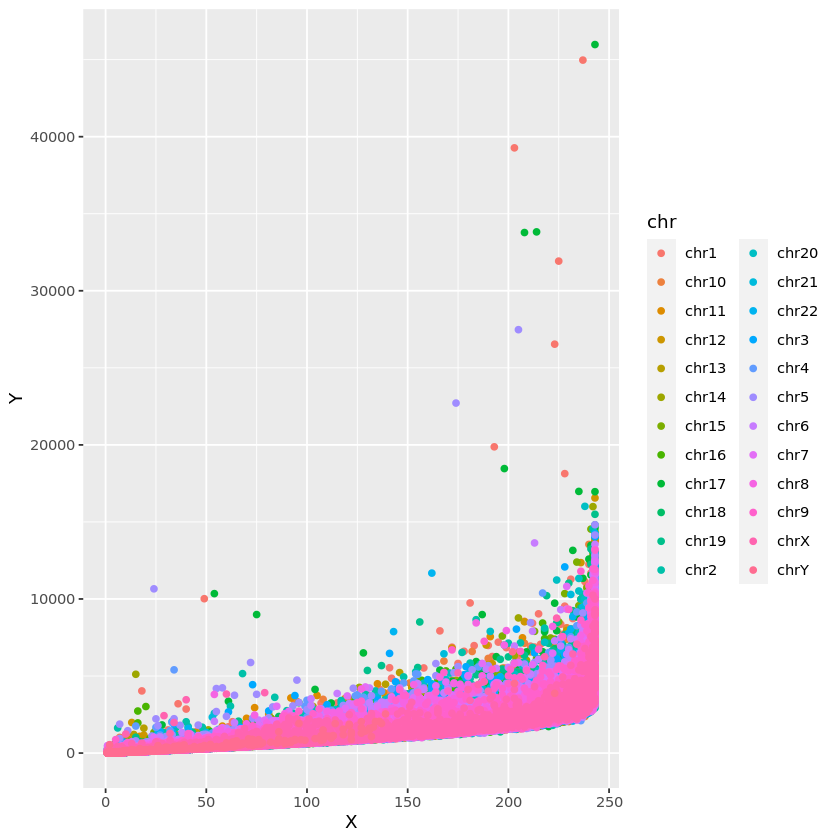

In [48]:
q=GRanges(seqnames="chr19",
          ranges=IRanges(start = 48364000, end = 48364600))

demo <- subsetByOverlaps(consensus_bed_chr19_motifs, q)

consensus_plot_df <- data.frame(X=demo$V6, Y=demo$V5)
# consensus_plot_df <- data.frame(X=consensus_bed$V6, Y=consensus_bed$V5, chr=consensus_bed@seqnames)

ggplot(data=consensus_plot_df, aes(x=X, y=Y, color=chr)) + geom_point()

# Line plot
# ggplot(data=consensus_plot_df, aes(x=X, y=Y, group=chr)) +
#   geom_line(color="red")+
#   geom_point()

In [130]:
# consensus_bed_chr19_motifs <- consensus_bed_chr19[!(consensus_bed_chr19$V12==""), ]